In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [2]:
cancer_rays_dir     = os.listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5") 

In [3]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['10295', '10304', '12868', '10274', '12818', '14190', '12869', '9323', '10291', '12906', '9176', '8984', '10299', '12930', '9344', '12935', '12894', '12909', '9381', '9346', '9175', '10262', '8980', '16896', '12241', '12910', '13617', '13401', '12891', '10300', '9076', '10259', '9124', '13402', '12870', '16550', '10255', '9261', '15471', '12931', '12955', '10258', '13461', '13023', '9260', '8957', '9035', '10268', '13403', '10288', '9262', '12911', '9319', '10254', '13616', '10253', '8974', '9135', '10257', '9291', '9320', '14209', '14078', '12749', '9043', '9041', '8975', '9075', '13025', '13021', '13458', '12901', '16552', '13688', '15902', '13692', '12879', '9073', '15514', '9325', '10277', '12810', '8864', '8917', '14305', '16167', '13022', '16555', '12932', '14189', '8867', '16166', '10290', '9083', '15840', '12907', '12880', '12908', '13693', '13591', '15516', '9228', '14192', '12949', '10306', '9345', '14156', '12872', '9123', '13019', '9226', '14304', '10260', '14154', '15472'

we clearly see that we have 279 files for each patient and each file contains x-Ray images of the patient 

**we need to make our work easier so we gathered all images in one place**

In [4]:
all_Xrays_img        = "all_Xrays_img"  # is this path we will put all the images
cancer_Xrays_dir ="../input/breast-histopathology-images/IDC_regular_ps50_idx5/"

In [5]:
# Directory path
dir_path = 'all_Xrays_img'

# Check if directory exists, create if not
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
else:
    print(f"The directory '{dir_path}' already exists.")

In [6]:
all_rays_dir_lst = os.listdir('./all_Xrays_img') 

In [7]:
import shutil 
#Here we will move the images, but by adding a small part in their path, which indicates that they are negative or positive
for patient in cancer_rays_dir:   
    path_0 = cancer_Xrays_dir + str(patient) + '/0'
    path_1 = cancer_Xrays_dir + str(patient) + '/1'
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_Xrays_img, fname)
            shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_Xrays_img, fname)
        shutil.copyfile(src, dst)

In [8]:
import os
all_rays_dir_lst = os.listdir('./all_Xrays_img') 
len(all_rays_dir_lst)

277524

**Put images into a DataFrame**

In [9]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

,image_id
0,9178_idx5_x1001_y1451_class0.png
1,8917_idx5_x151_y1751_class0.png
2,10307_idx5_x2101_y851_class0.png
3,14192_idx5_x2151_y2101_class0.png
4,14304_idx5_x2101_y1701_class0.png


In [10]:
# extract a specific target value from the image_id column of the data DataFrame and store it in a new column called target
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

,image_id,target
0,9178_idx5_x1001_y1451_class0.png,0
1,8917_idx5_x151_y1751_class0.png,0
2,10307_idx5_x2101_y851_class0.png,0
3,14192_idx5_x2151_y2101_class0.png,0
4,14304_idx5_x2101_y1701_class0.png,0
5,10285_idx5_x501_y701_class0.png,0
6,9290_idx5_x1401_y301_class1.png,1
7,9254_idx5_x1301_y1651_class0.png,0
8,8918_idx5_x2101_y2151_class0.png,0
9,9254_idx5_x2851_y1051_class1.png,1


In [11]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

,image_id,target,patient_id
0,9178_idx5_x1001_y1451_class0.png,0,9178
1,8917_idx5_x151_y1751_class0.png,0,8917
2,10307_idx5_x2101_y851_class0.png,0,10307
3,14192_idx5_x2151_y2101_class0.png,0,14192
4,14304_idx5_x2101_y1701_class0.png,0,14304


In [12]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

The number of healthy X Rays is more than unhealthy X Rays

**Data Investigation**

Healthy Patches

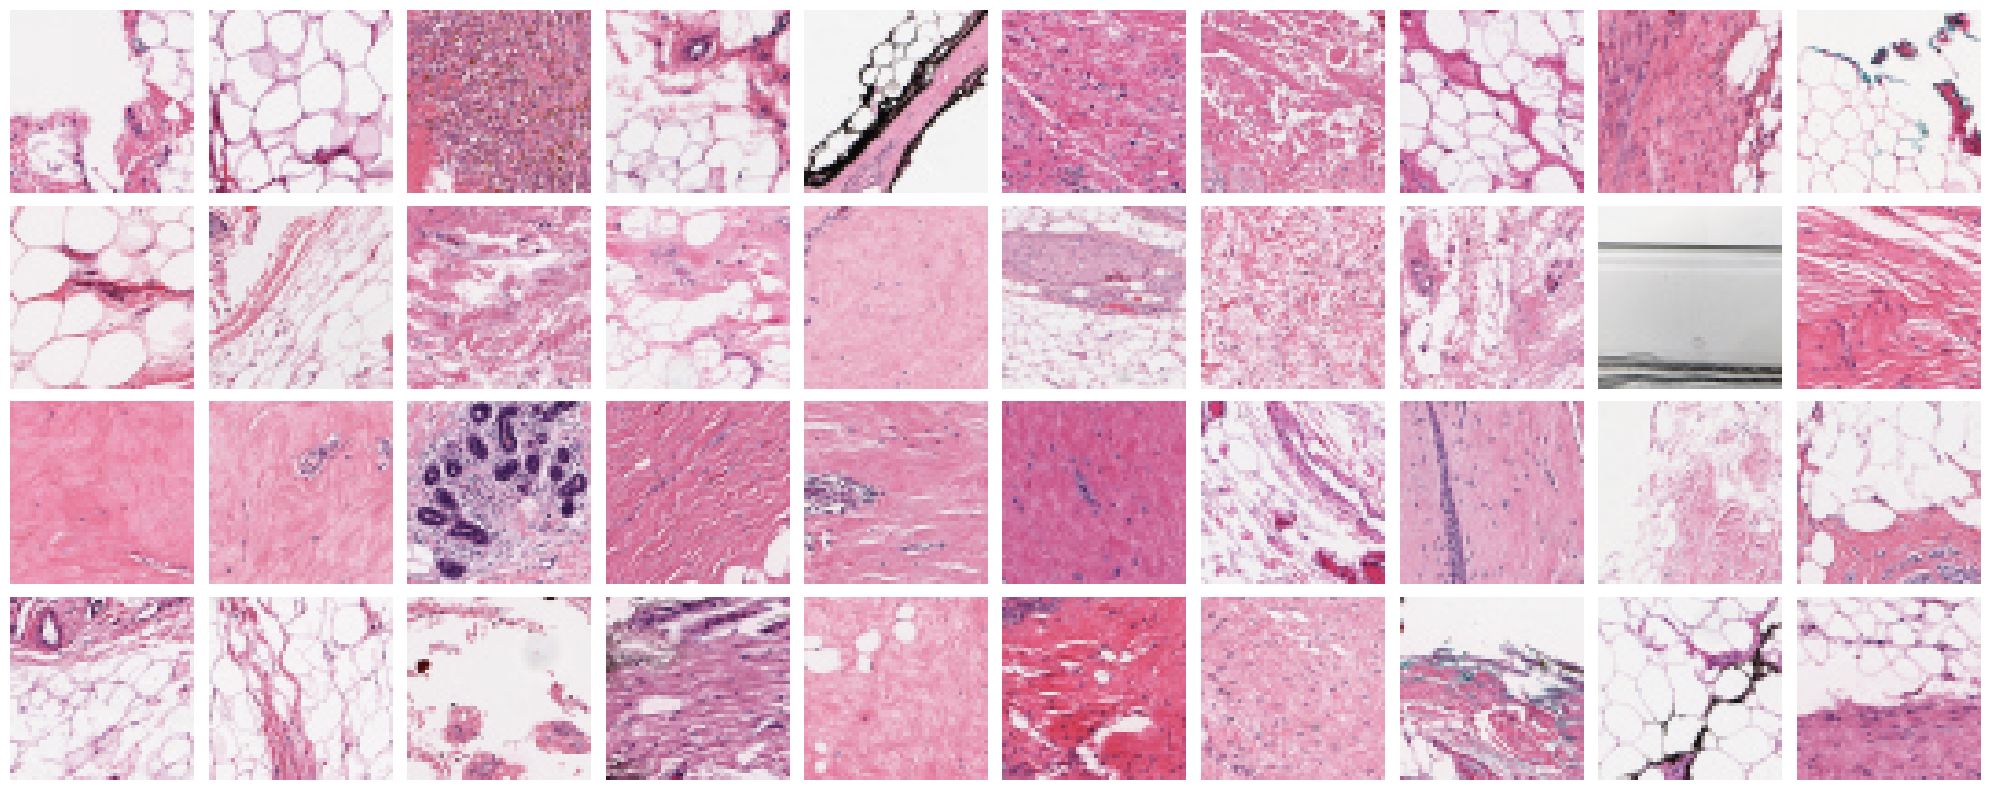

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
data.target = data.target.astype(int)

# Create a figure with 4 rows and 10 columns (total 40 images)
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

# Select 40 random negative samples (target == 0)
neg_selection = np.random.choice(data[data.target == 0].index, size=40, replace=False)

# Loop through the grid to display images
for n in range(4):  # Loop over 4 rows
    for m in range(10):  # Loop over 10 columns
        idx = neg_selection[m + 10 * n]  # Select an index from the 40 negative samples
        path = os.path.join(all_Xrays_img , data.loc[idx, 'image_id'])  # Construct the image path
        image = mpimg.imread(path)  # Read the image
        ax[n, m].imshow(image)  # Display the image in the corresponding subplot
        ax[n, m].axis("off")  # Hide axis for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

Unhealthy Patches (Cancer Patches)

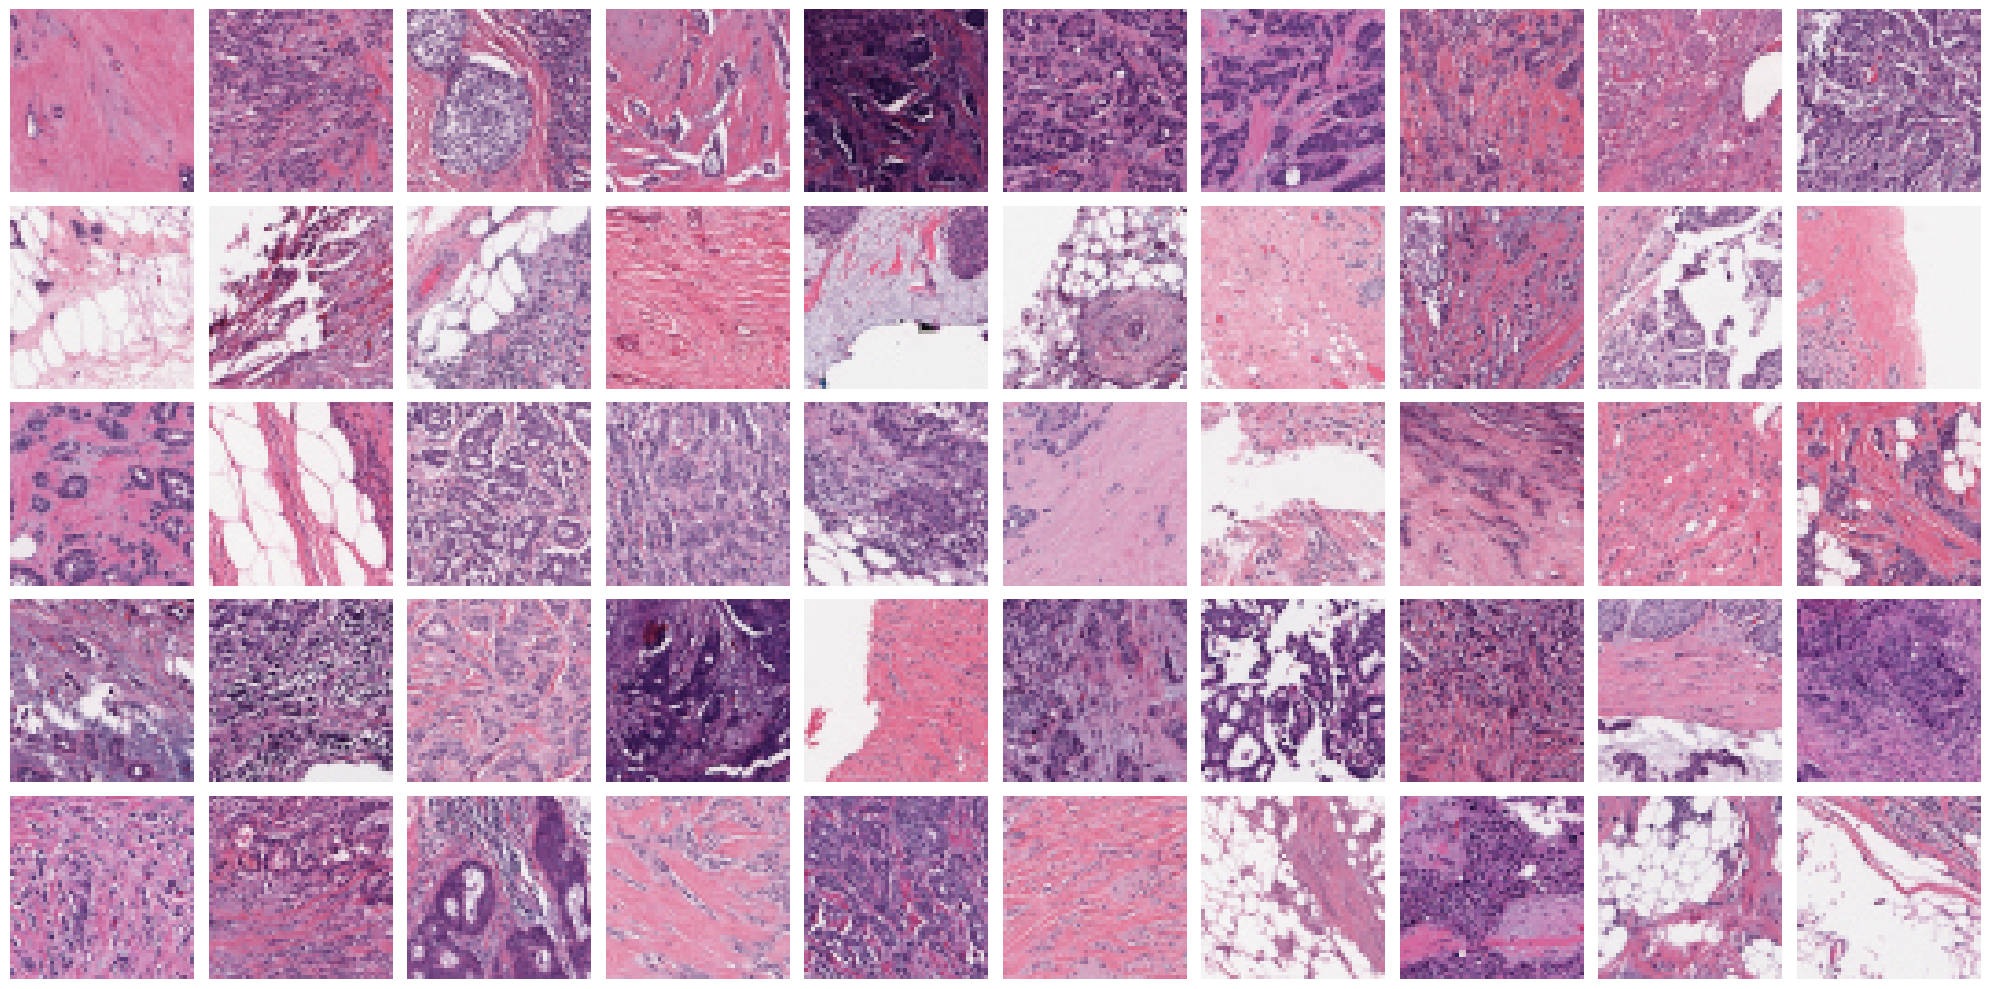

In [14]:
# Convert target column to integer type
data.target = data.target.astype(int)

# Create a figure with 5 rows and 10 columns (total 50 images)
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

# Select 50 random unhealthy patches (target == 1)
unhealthy_selection = np.random.choice(data[data.target == 1].index, size=50, replace=False)

# Loop through the grid to display images
for n in range(5):  # Loop over 5 rows
    for m in range(10):  # Loop over 10 columns
        idx = unhealthy_selection[m + 10 * n]  # Select an index from unhealthy samples
        path = os.path.join(all_Xrays_img, data.loc[idx, 'image_id'])  # Construct the image path
        image = mpimg.imread(path)  # Read the image
        ax[n, m].imshow(image)  # Display the image in the corresponding subplot
        ax[n, m].axis("off")  # Hide axis for cleaner display

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

### ✅ Summary of Steps  
1. **Check the number of mammograms per patient.**  
   - Helps determine if all patients contribute the same number of images.  
   - Identifies potential biases in the dataset.  

2. **Calculate and analyze the IDC percentage.**  
   - Measures the proportion of cancerous tissue in each mammogram.  
   - Helps assess the severity of detected cancer cases.  

3. **Count and visualize the number of healthy vs. cancerous mammograms.**  
   - Checks for class imbalance in the dataset.  
   - Guides data preprocessing strategies like oversampling or undersampling.  


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


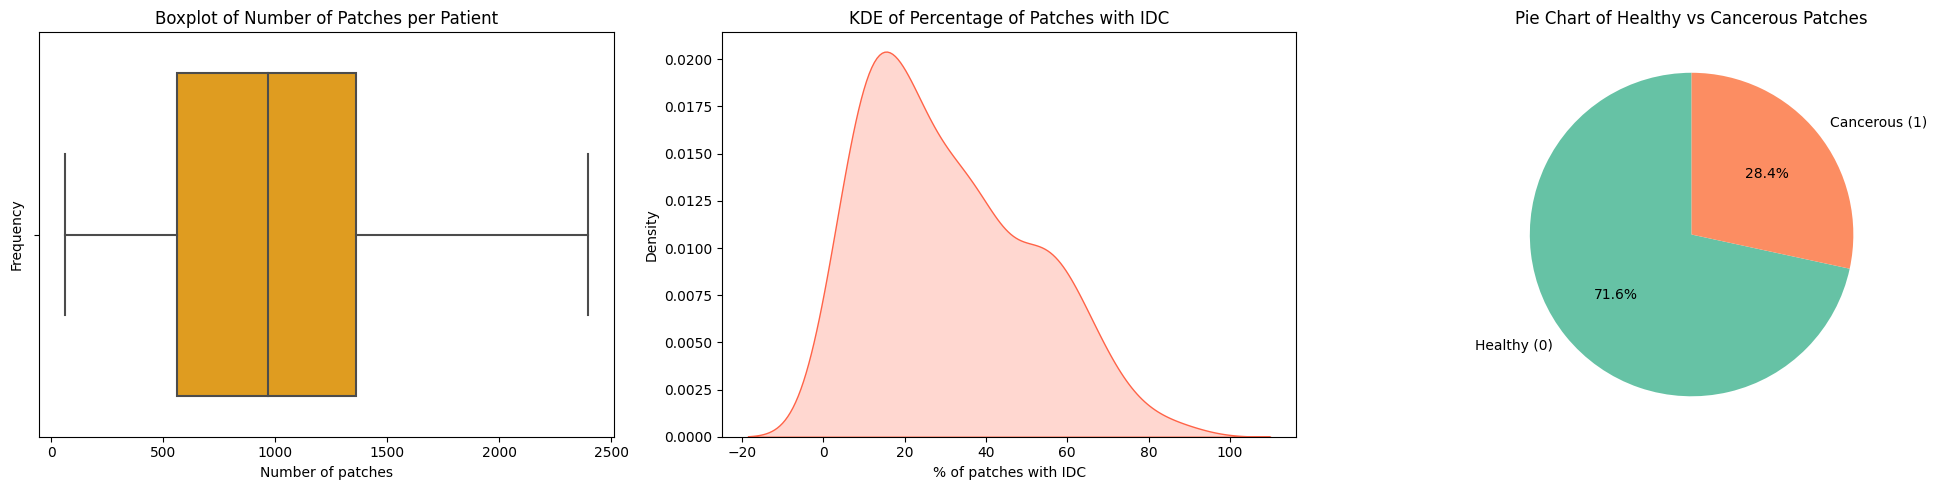

In [15]:
import seaborn as sns
# Compute cancer percentage per patient
cancer_perc = data.groupby("patient_id")["target"].value_counts() / data.groupby("patient_id")["target"].size()
cancer_perc = cancer_perc.unstack().fillna(0)  # Ensure missing values are handled

# Create figure and axes
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Step 1: How many patches do we have per patient?
sns.boxplot(x=data.groupby("patient_id").size(), ax=ax[0], color="Orange")
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Boxplot of Number of Patches per Patient")

# Step 2: How much percentage of an image is covered by IDC?
sns.kdeplot(cancer_perc.loc[:, 1] * 100, ax=ax[1], color="Tomato", fill=True)  # Use fill=True instead of shade=True
ax[1].set_title("KDE of Percentage of Patches with IDC")
ax[1].set_ylabel("Density")
ax[1].set_xlabel("% of patches with IDC")

# Step 3: How many patches show IDC?
target_counts = data['target'].value_counts()
labels = ['Healthy (0)', 'Cancerous (1)']
ax[2].pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
ax[2].set_title("Pie Chart of Healthy vs Cancerous Patches")

plt.tight_layout()
plt.show()

In [16]:

def extract_coords(df):
    """Extracts x and y coordinates from the file path column."""
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    
    # Convert coordinates from string to integer
    coord.loc[:, "x"] = coord.loc[:, "x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:, "y"].str.replace("y", "", case=False).astype(int)
    
    # Assign extracted coordinates back to the dataframe
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    """Creates a DataFrame for a given patient and cancer status (0 = healthy, 1 = cancerous)."""
    path = os.path.join(cancer_Xrays_dir, patient_id, cancer_id)  # Corrected path joining
    files = os.listdir(path)
    
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = [os.path.join(path, fname) for fname in dataframe["filename"]]  # Ensuring correct file paths
    
    # Extract filename components
    dataframe = dataframe["filename"].str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)  # Replaced np.int with int
    dataframe.loc[:, "path"] = path_names
    
    # Extract x and y coordinates
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:, "x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:, "y"].str.replace("y", "", case=False).astype(int)
    
    return dataframe

def get_patient_dataframe(patient_id):
    """Combines both healthy (0) and cancerous (1) image data for a given patient."""
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    
    # Use pd.concat instead of deprecated .append()
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

### `extract_coords(df)` function:
- **What it does**: This function helps to map where each image is located (by its x, y position) and stores it in a way that can be used later for analysis.

---

### `get_cancer_dataframe(patient_id, cancer_id)` function:
- **What it does**: 
  - It gets a list of filenames from the directory where the images are kept.
  - Each filename is then processed to extract the coordinates (x and y), and the cancer status is added (0 for healthy, 1 for cancerous).
  - It returns a table with the filename, the coordinates (x, y), and whether the image shows cancer (target).
  
- **Why is this useful?**: It organizes the data for one patient, showing both healthy and cancerous images, and adds useful information (coordinates, cancer status) for each image.

---

### `get_patient_dataframe(patient_id)` function:
- **What it does**: 
  - This function takes a `patient_id` and combines the data from both healthy and cancerous images into one table.
  - It calls `get_cancer_dataframe` twice — once for healthy images (`cancer_id = 0`) and once for cancerous images (`cancer_id = 1`).
  
- **Why is this useful?**: It creates a complete set of data for all of a patient’s mammograms, both healthy and cancerous, and stores them in one table for easier analysis.


In [17]:
example = get_patient_dataframe(data.patient_id.values[1])
example.head()

,x,y,target,path
0,201,1751,0,../input/breast-histopathology-images/IDC_regu...
1,1451,1151,0,../input/breast-histopathology-images/IDC_regu...
2,451,2101,0,../input/breast-histopathology-images/IDC_regu...
3,1051,1751,0,../input/breast-histopathology-images/IDC_regu...
4,401,1701,0,../input/breast-histopathology-images/IDC_regu...


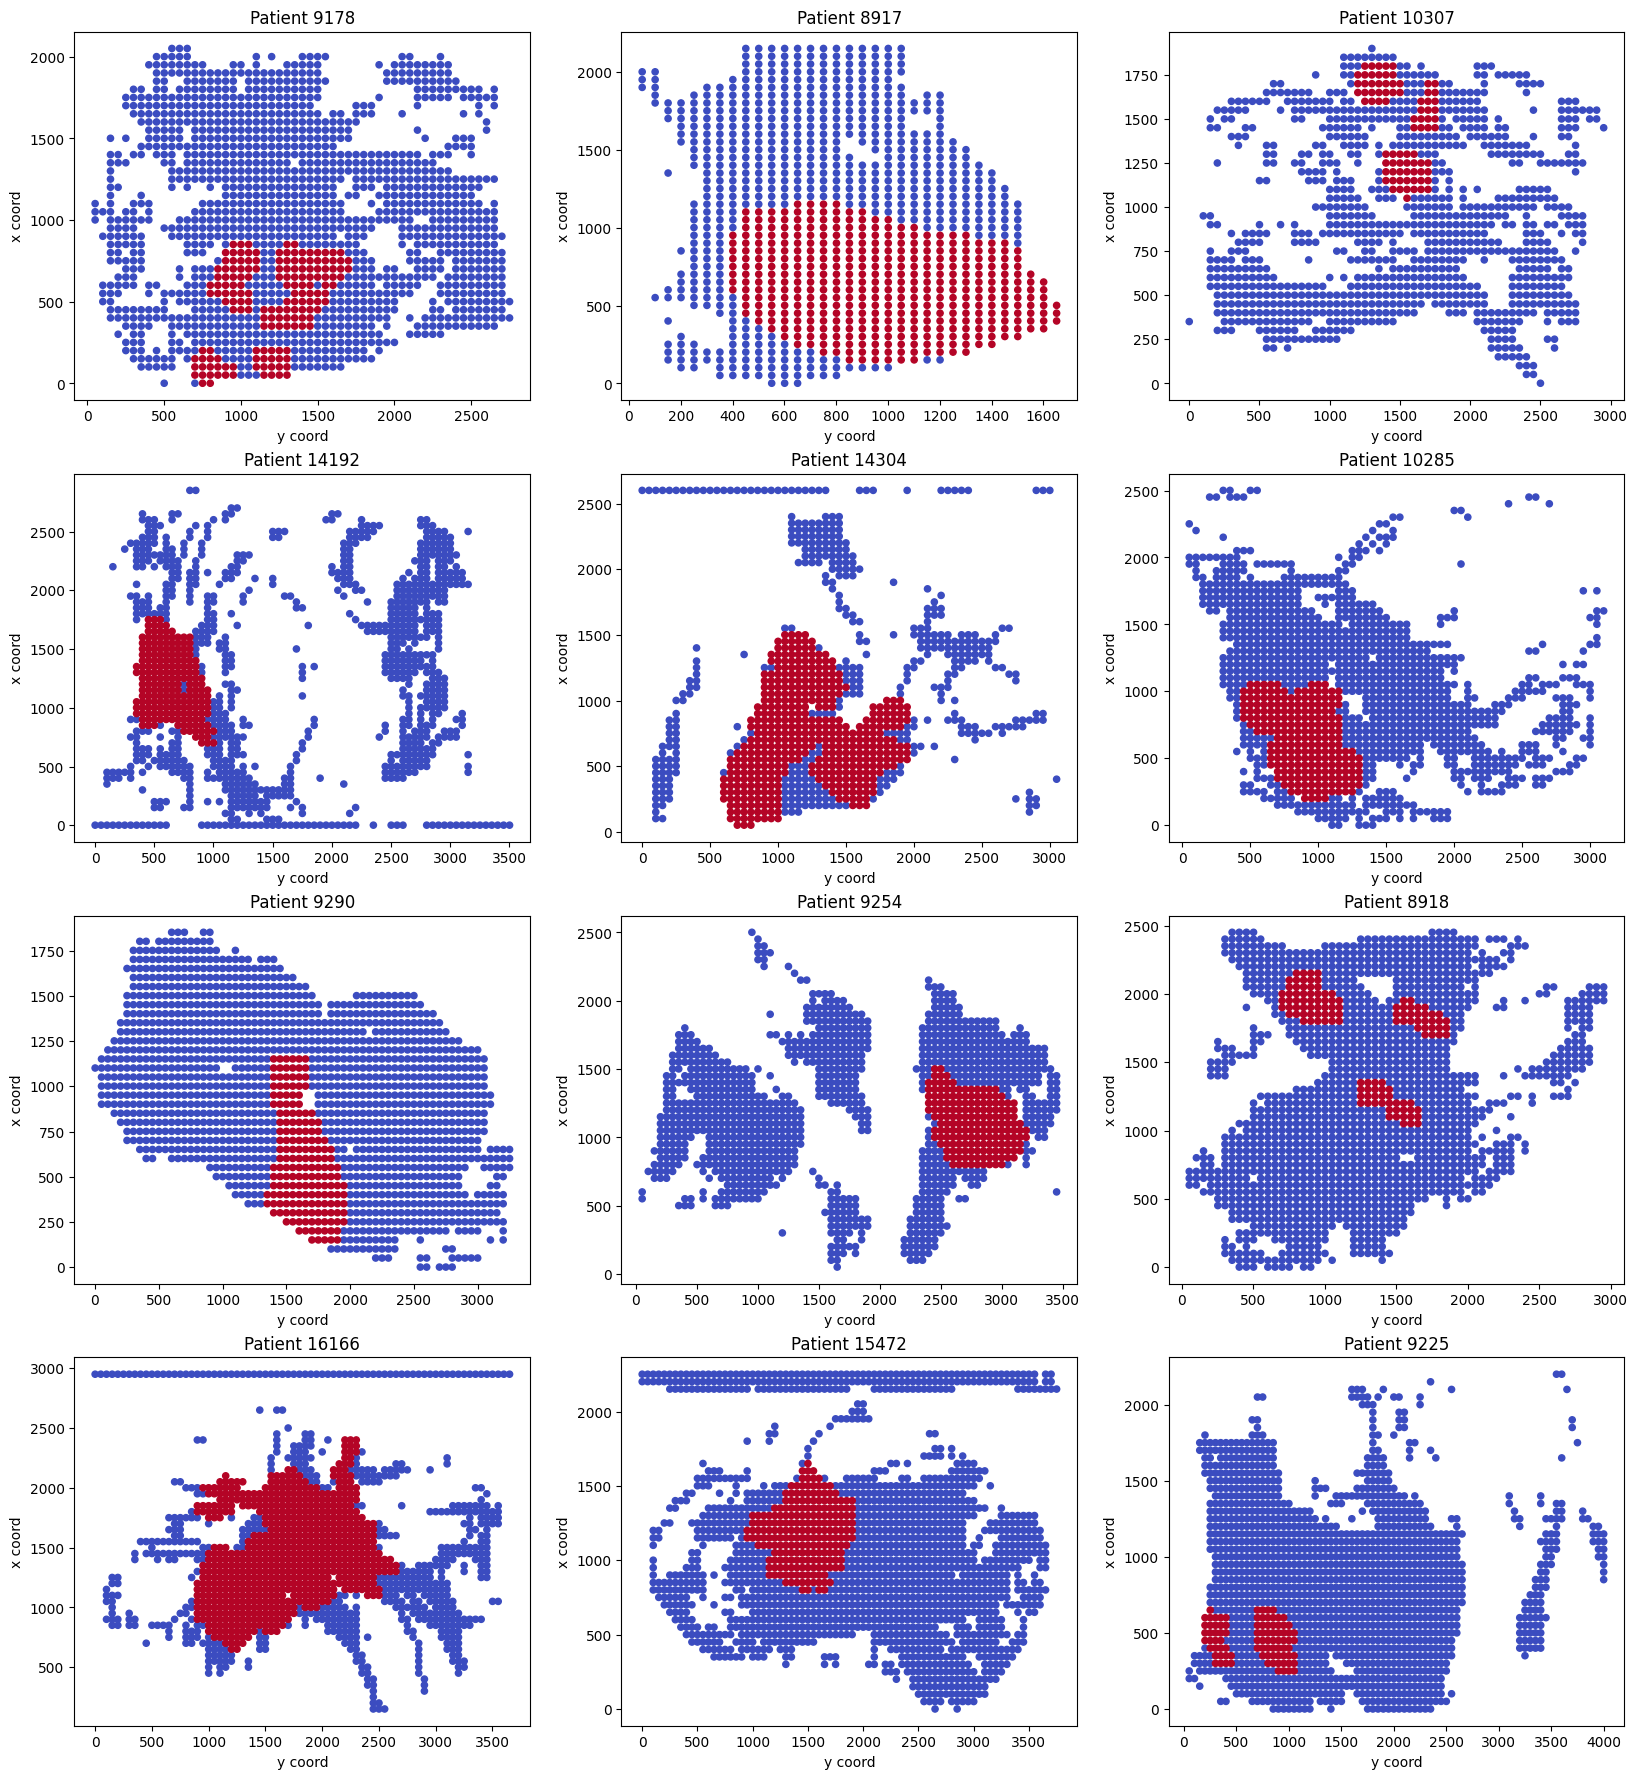

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(20, 22))

patient_ids = data.patient_id.unique()

for n in range(4):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20)
        ax[n,m].set_title("Patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")


### Code Explanation:

This code generates a **grid of 12 scatter plots** (4 rows, 3 columns), where each plot represents the **coordinates of mammogram patches** for a different patient.

- **The color of each point (patch)** indicates whether it is **healthy (cool colors)** or **cancerous (dark colors)**.
- The **x-axis and y-axis** show the **coordinates** of the patches on the image.

### Cool and Dark Color Mapping:
- **Cool colors** (blue shades) represent **healthy** patches (`target = 0`).
- **Dark colors** (red shades) represent **cancerous** patches (`target = 1`).

This visualization helps us understand how the **healthy and cancerous patches** are distributed across different patients' mammograms, and it shows the position of each patch (healthy or cancerous) on the images.

**Image transformation**

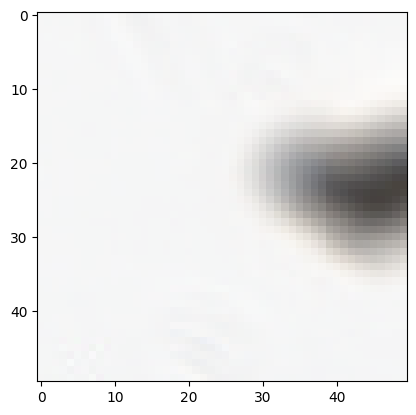

In [19]:
data.target = data.target.astype(int)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_Xrays_img ,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

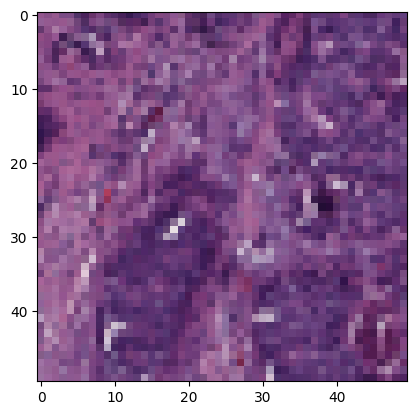

In [20]:
data.target = data.target.astype(int)
random_image_path = np.random.choice(data[data.target == 1].index, size=1, replace=False,)
path = os.path.join(all_Xrays_img, data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

### Noise Reduction via Gaussian Filter

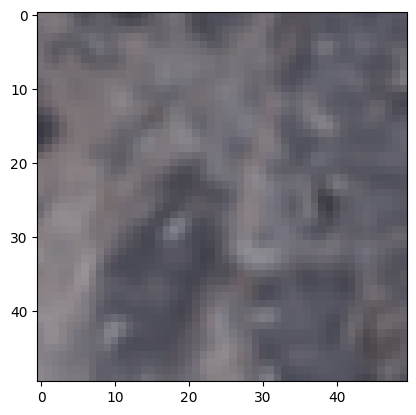

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Apply Gaussian filter
gaussian_image = gaussian_filter(image, sigma=1)  # 'sigma' controls the amount of blurring

# Display the resulting image
plt.imshow(gaussian_image)
plt.show()


### Gaussian Blur: A Smoothing Technique

**Gaussian blur** is a smoothing technique that reduces image noise and detail by averaging pixel values in the neighborhood using a **Gaussian function**.

#### Why Use It?

- **Focus on Larger Structures**: It can make the **Convolutional Neural Network (CNN)** focus on **larger structures** (e.g., tumors) instead of small details or noise.
  
- **Reduction of High-Frequency Information**: It helps in reducing **high-frequency information**, like sudden pixel intensity changes, which might not be relevant for detecting cancer.


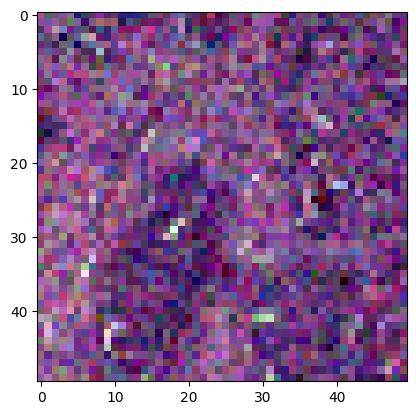

In [22]:
from skimage.util import random_noise
noise_image = random_noise(image)
plt.imshow(noise_image)

### Random Noise: Adding Variations to Images

**Random noise** means adding small, random variations to pixel values in an image, making it look grainy.

#### Why Use It?

- **Model Robustness**: To make the model more **robust** and prevent it from **overfitting** to clean data.
  
- **Simulating Real-World Conditions**: It simulates **real-world conditions** where images might not be perfectly clean, ensuring the **Convolutional Neural Network (CNN)** learns to **generalize better**.


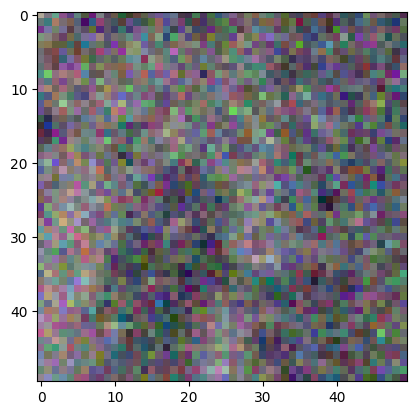

In [23]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

### Combining Noise with the Blurred Image

- **`noiseGaussianImage = random noise + Gaussian image`**

- This step combines the **Gaussian-blurred image** with the **random noise**, resulting in a new, slightly altered version of the original image.

#### Why?

This might serve two purposes:

1. **Augmented Dataset**: It creates an **augmented dataset** by introducing variation in the input images, helping the model **generalize better**.

2. **Retaining Benefits**: It retains the benefits of both **blurring** (reducing irrelevant details) and **noise** (improving robustness).


**Processing**

Creation of new file that we gonna put noisy images in

In [24]:
# Check if the 'image_processing' directory exists, create if not
if not os.path.exists('image_processing'):
    os.mkdir('image_processing')

# Check if the 'noise_images' directory exists, create if not
if not os.path.exists('image_processing/noise_images'):
    os.mkdir('image_processing/noise_images')

In [25]:
for normal_image in all_rays_dir_lst :
    path        = all_Xrays_img +'/'+ normal_image
    img         = mpimg.imread( path ,0)
    noise_image = random_noise(img)
    fname       = normal_image
    new_path    = os.path.join('image_processing/noise_images',fname)
    mpimg.imsave(new_path, noise_image)

### Adding Random Noise to Images and Saving Them

This code **loops over the images** in the directory, **adds random noise** to each image, and **saves the noisy images** to a new directory (`image_processing/noise_images`).


In [26]:
os.mkdir( 'image_processing/processd_data_train')
os.mkdir( 'image_processing/processd_data_test')
os.mkdir( 'image_processing/processd_data_train/zeros')
os.mkdir( 'image_processing/processd_data_train/ones')
os.mkdir( 'image_processing/processd_data_test/zeros')
os.mkdir( 'image_processing/processd_data_test/ones')

### Organizing Data into Directories

The code organizes the data by creating separate folders for **training** and **test** data.


### Creation of a DataFrame that contains the Processed images

In [27]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

,image_id
0,9178_idx5_x1001_y1451_class0.png
1,8917_idx5_x151_y1751_class0.png
2,10307_idx5_x2101_y851_class0.png
3,14192_idx5_x2151_y2101_class0.png
4,14304_idx5_x2101_y1701_class0.png


### Adding the target column

In [28]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

,image_id,target
0,9178_idx5_x1001_y1451_class0.png,0
1,8917_idx5_x151_y1751_class0.png,0
2,10307_idx5_x2101_y851_class0.png,0
3,14192_idx5_x2151_y2101_class0.png,0
4,14304_idx5_x2101_y1701_class0.png,0
5,10285_idx5_x501_y701_class0.png,0
6,9290_idx5_x1401_y301_class1.png,1
7,9254_idx5_x1301_y1651_class0.png,0
8,8918_idx5_x2101_y2151_class0.png,0
9,9254_idx5_x2851_y1051_class1.png,1


In [29]:
processd_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

**TEST/TRAIN Split**

In [30]:
from sklearn.model_selection import train_test_split
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)


**Extracting image_id for the test and Train**

It facilitates loading images from storage with just the image_id

In [31]:
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

### Moving test images into the correct subfolders (zeros for healthy, ones for cancerous) inside the test dataset directory by labeling 0 for zeros and 1 for ones

In [32]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)

### Moving train images into the correct subfolders (zeros for healthy, ones for cancerous) inside the test dataset directory by labeling 0 for zeros and 1 for ones

In [33]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [34]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

178864
70907
19874
7879


### Modeling

### **Image Rescaling with ImageDataGenerator**  

The ImageDataGenerator is used to preprocess images before feeding them into a deep learning model.  

#### **What does it do?**  
- **Rescales pixel values** from the range **0-255** to **0-1** using `rescale=1.0/255`.  
- **Helps models train efficiently** by ensuring consistent input values.  
- **Improves performance** by normalizing data, making it easier for the model to learn patterns.  


In [35]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [36]:
train_generation = data_generation.flow_from_directory(
                                        "image_processing/processd_data_train",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "image_processing/processd_data_test",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')

Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


**Model Architecture**

In [37]:
Model =Sequential()
Model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
Model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(.3))

Model.add(Flatten())

Model.add(Dense(256,activation='relu'))

Model.add(Dense(2,activation='softmax'))

Model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 22, 22, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 19, 19, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2592)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         663,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,306 (2.60 MB)

 Trainable params: 682,306 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
Model.fit(train_generation,validation_data=test_generation,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24978/24978 ━━━━━━━━━━━━━━━━━━━━ 167s 7ms/step - accuracy: 0.8001 - loss: 0.4470 - val_accuracy: 0.8306 - val_loss: 0.3913
Epoch 2/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 154s 6ms/step - accuracy: 0.8296 - loss: 0.3951 - val_accuracy: 0.8401 - val_loss: 0.3721
Epoch 3/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 153s 6ms/step - accuracy: 0.8365 - loss: 0.3843 - val_accuracy: 0.8327 - val_loss: 0.3973
Epoch 4/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 153s 6ms/step - accuracy: 0.8394 - loss: 0.3755 - val_accuracy: 0.8442 - val_loss: 0.3732
Epoch 5/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 154s 6ms/step - accuracy: 0.8424 - loss: 0.3709 - val_accuracy: 0.8491 - val_loss: 0.3565
Epoch 6/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 153s 6ms/step - accuracy: 0.8436 - loss: 0.3692 - val_accuracy: 0.8461 - val_loss: 0.3745
Epoch 7/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 153s 6ms/step - accuracy: 0.8447 - loss: 0.3651 - val_accuracy: 0.8459 - val_loss: 0.3710
Epoch 8/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 153s 6ms/step - accuracy: 0.8

**Results**

In [40]:
losse = pd.DataFrame(Model.history.history)
losse.head()

,accuracy,loss,val_accuracy,val_loss
0,0.817345,0.420380,0.830613,0.391268
1,0.831578,0.391795,0.840125,0.372066
2,0.836734,0.382040,0.832703,0.397322
3,0.839897,0.375379,0.844197,0.373166
4,0.842087,0.371143,0.849061,0.356451


<Axes: >

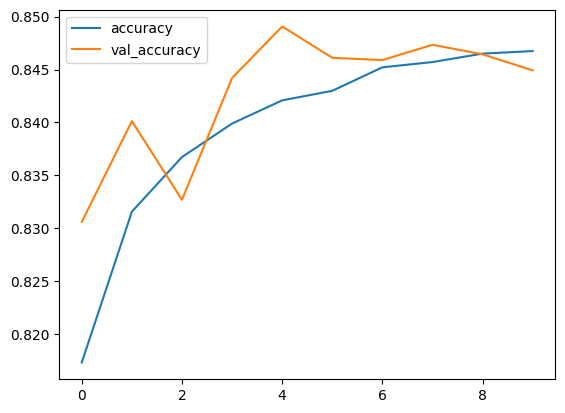

In [41]:
losse[['accuracy','val_accuracy']].plot()

<Axes: >

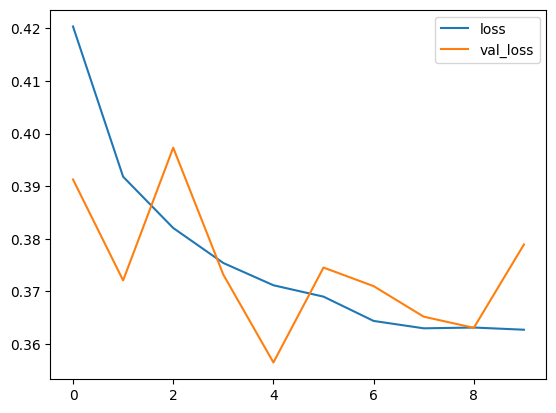

In [42]:
losse[['loss','val_loss']].plot()

In [43]:
val_loss, val_acc = Model.evaluate(test_generation)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4%}')

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8469 - loss: 0.3764
Validation Loss: 0.3789
Validation Accuracy: 84.4918%


### Saving and Loading the Model

In [44]:
from tensorflow.keras.models import model_from_json
model_json = Model.to_json()

**Saving the model architecture and it's weights**

In [45]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
my_model.save_weights("model.h5")
print("Saved model to disk")

NameError: name 'my_model' is not defined

**Loading the Model**

In [ ]:
from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read() #Loads the saved model architecture from the model.json file.
json_file.close()
loaded_model = model_from_json(loaded_model_json) #Recreates the model structure from the JSON file.
loaded_model.load_weights("model.h5") # Loads the saved weights into the model
print("Loaded model from disk") 
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Compiles the model again so it can be used for predictions or further training.